In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
df = pd.read_csv('../data/preprocessed/AMZN_stock_data_processed.csv')  

In [3]:
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Days,50_MA,200_MA,Daily Change
0,1997-05-15 04:00:00+00:00,0.121875,0.125000,0.096354,0.097917,1443120000,0.0,0.0,0,NaN,NaN,-0.023958
1,1997-05-16 04:00:00+00:00,0.098438,0.098958,0.085417,0.086458,294000000,0.0,0.0,1,NaN,NaN,-0.011980
2,1997-05-19 04:00:00+00:00,0.088021,0.088542,0.081250,0.085417,122136000,0.0,0.0,4,NaN,NaN,-0.002604
3,1997-05-20 04:00:00+00:00,0.086458,0.087500,0.081771,0.081771,109344000,0.0,0.0,5,NaN,NaN,-0.004687
4,1997-05-21 04:00:00+00:00,0.081771,0.082292,0.068750,0.071354,377064000,0.0,0.0,6,NaN,NaN,-0.010417


In [30]:
df.index = pd.to_datetime(df.index)
X = df[['Days']]
y = df['Close']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [33]:
y_pred = model.predict(X_test)

In [34]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Mean Squared Error: 1126.715343721218
R^2 Score: 0.6711617346425536


In [35]:
future_days = pd.DataFrame(np.arange(df['Days'].max() + 1, df['Days'].max() + 91), columns=['Days'])
future_pred = model.predict(future_days)

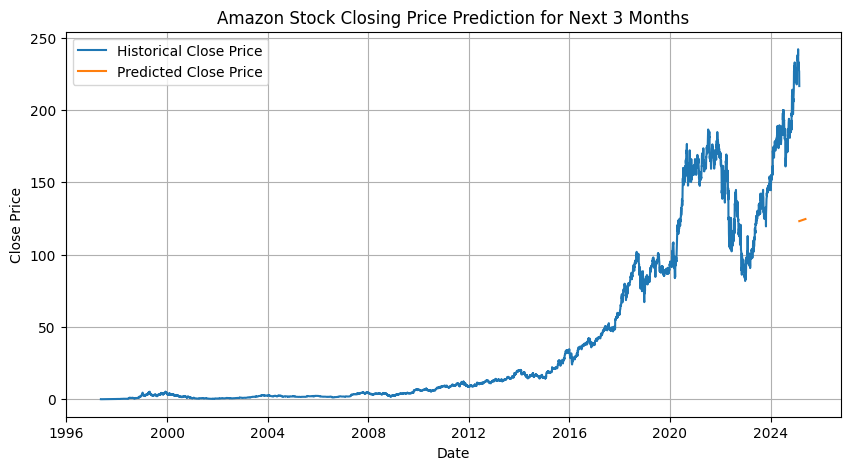

In [36]:

plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Close'], label='Historical Close Price')
plt.plot(pd.date_range(df.index[-1], periods=90, freq='D'), future_pred, label='Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Amazon Stock Closing Price Prediction for Next 3 Months')
plt.legend()
plt.grid(True)
plt.show()

In [37]:
import json
predicted_dates = pd.date_range(start=df.index[-1], periods=90, freq='D')
predicted_prices = future_pred

predictions = {str(date.date()): price for date, price in zip(predicted_dates, predicted_prices)}

with open('../outputs/predictions/predicted_prices_3months_LR.json', 'w') as json_file:
    json.dump(predictions, json_file, indent=4)


#### Now I am going to do the forecasts with multiple features (multivariate) not just the days difference 

In [52]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb

features = ['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits']
target = 'Close'


In [53]:
X = df[features]
y = df[target]

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Training set shape:', X_train.shape)
print('Test set shape:', X_test.shape)

Training set shape: (5589, 6)
Test set shape: (1398, 6)


In [55]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(n_estimators=100),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100),
    "XGBoost": xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100)
}

                   R2 Score      RMSE
Linear Regression  0.999931  0.487740
Decision Tree      0.999833  0.756297
Random Forest      0.999890  0.613776
Gradient Boosting  0.999841  0.737342
XGBoost            0.999694  1.023933


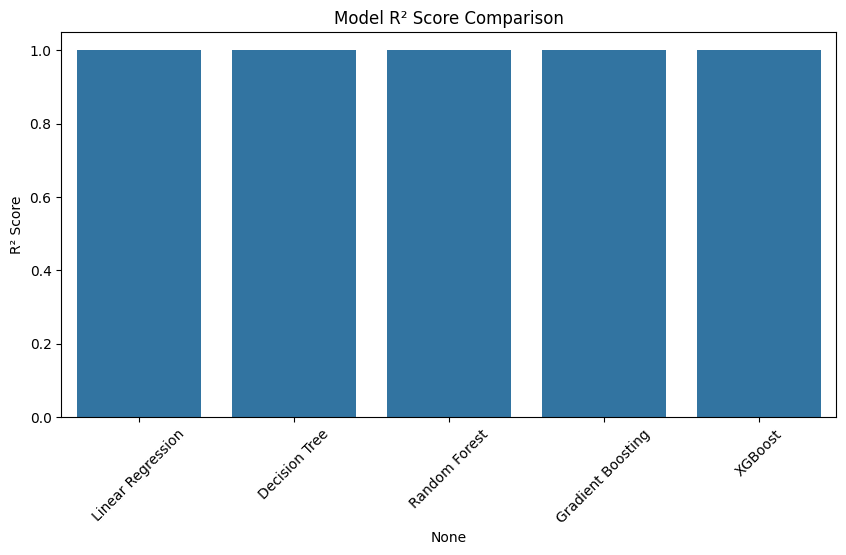

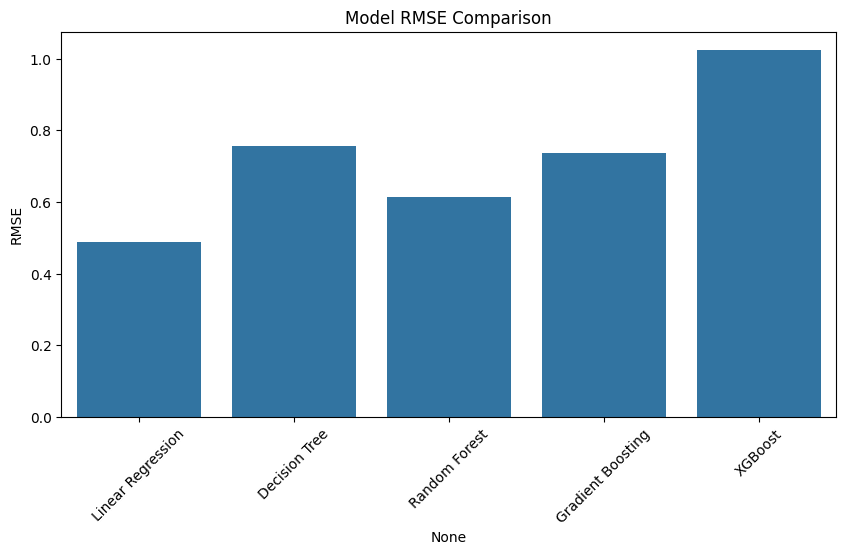

In [57]:

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results[name] = {"R2 Score": r2, "RMSE": rmse}

results_df = pd.DataFrame(results).T

print(results_df)

plt.figure(figsize=(10, 5))
sns.barplot(x=results_df.index, y=results_df["R2 Score"])
plt.title("Model R² Score Comparison")
plt.ylabel("R² Score")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x=results_df.index, y=results_df["RMSE"])
plt.title("Model RMSE Comparison")
plt.ylabel("RMSE")
plt.xticks(rotation=45)
plt.show()

C:\Users\LapTop\AppData\Local\Temp\ipykernel_17440\3275783917.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="R2 Score (%)", data=results_df, palette="Blues_r")


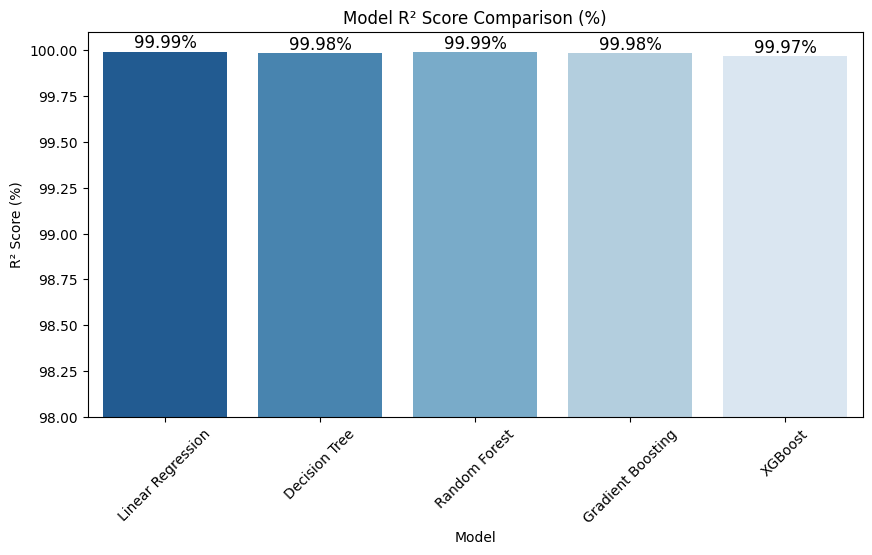

C:\Users\LapTop\AppData\Local\Temp\ipykernel_17440\3275783917.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="RMSE (%)", data=results_df, palette="Reds_r")


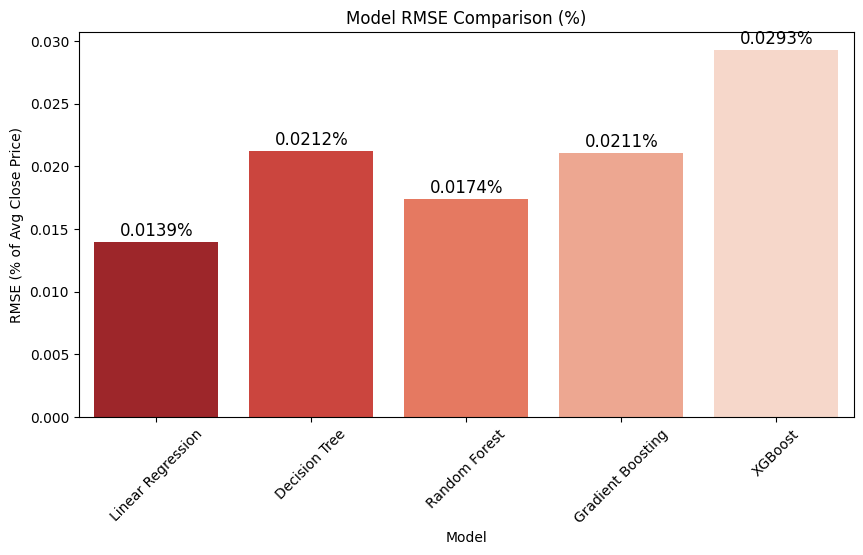

In [59]:
results = {
    "Model": ["Linear Regression", "Decision Tree", "Random Forest", "Gradient Boosting", "XGBoost"],
    "R2 Score": [0.999931, 0.999839, 0.999892, 0.999841, 0.999694],
    "RMSE": [0.487740, 0.742821, 0.608895, 0.737006, 1.023933]
}

results_df = pd.DataFrame(results)

results_df["R2 Score (%)"] = results_df["R2 Score"] * 100

avg_close_price = 3500 
results_df["RMSE (%)"] = (results_df["RMSE"] / avg_close_price) * 100

plt.figure(figsize=(10, 5))
sns.barplot(x="Model", y="R2 Score (%)", data=results_df, palette="Blues_r")
plt.title("Model R² Score Comparison (%)")
plt.ylabel("R² Score (%)")
plt.ylim(98, 100.1)
plt.xticks(rotation=45)

for index, value in enumerate(results_df["R2 Score (%)"]):
    plt.text(index, value + 0.02, f"{value:.2f}%", ha='center', fontsize=12)

plt.savefig("../outputs/figures/ML_models_r2_score_comparison.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x="Model", y="RMSE (%)", data=results_df, palette="Reds_r")
plt.title("Model RMSE Comparison (%)")
plt.ylabel("RMSE (% of Avg Close Price)")
plt.xticks(rotation=45)

for index, value in enumerate(results_df["RMSE (%)"]):
    plt.text(index, value + 0.0005, f"{value:.4f}%", ha='center', fontsize=12)
plt.savefig("../outputs/figures/ML_models_RMSE_comparison.png", format='png', dpi=300, bbox_inches='tight')
plt.show()